In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import scipy.optimize as opt
from tqdm import trange

from dnn.utils.mem import set_memory_growth
from dnn.utils.params import ParamDict as o
from dnn.sindy.model import SINDYcModel

set_memory_growth()

In [2]:
p = o.from_file('../code/dnn/sindy/lorenz_params.py')
sindy = SINDYcModel(3, 1, p.library)

In [3]:
sindy.load_weights('/sessions/control/sindy/lorenz/sess_2020-12-11_10-28-35_reg/noise_0.01/1.h5')

In [4]:
val_data = np.load('/data/control/lorenz/val.npy')

In [5]:
STEPS = 5000
x = val_data['state'][0].copy()
x_bx = np.zeros((STEPS, x.shape[0]))
for i in range(STEPS):
    x_bx[i] = x
    u = val_data['control'][i]
    x += 1e-3 * sindy((x[None], u[None]))[0].numpy()

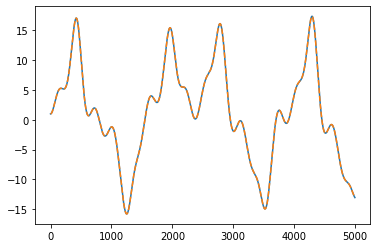

In [6]:
plt.plot(val_data['state'][:STEPS, 0])
plt.plot(x_bx[:, 0], '--')

In [7]:
PRED_HORIZON = 40
CTRL_HORIZON = 40
NUM_STATE = val_data['state'].shape[-1]
NUM_CONTROL = val_data['control'].shape[-1]
Q = np.diag([1e-1, 1e-1, 1e-1])
R = 4e-3
dt = 1e-1
SCALE = 30

@tf.function
def cost_fun(vals, xs_ref):
    with tf.GradientTape() as tape:
        tape.watch(vals)
        xs = tf.reshape(vals[:PRED_HORIZON * NUM_STATE], (PRED_HORIZON, NUM_STATE))
        us = tf.reshape(vals[PRED_HORIZON * NUM_STATE:], (CTRL_HORIZON, NUM_CONTROL))
        xs_delta = xs - xs_ref
        cost = tf.linalg.trace(xs_delta @ Q @ tf.transpose(xs_delta)) + \
               tf.linalg.trace(us @ tf.transpose(us)) * R
    
    grad = tape.gradient(cost, vals)
    
    return cost, grad

@tf.function
def dynamic_fun(vals, x0):
    with tf.GradientTape() as tape:
        tape.watch(vals)
        xs = tf.reshape(vals[:PRED_HORIZON * NUM_STATE], (PRED_HORIZON, NUM_STATE))
        us = tf.reshape(vals[PRED_HORIZON * NUM_STATE:], (CTRL_HORIZON, NUM_CONTROL))
        x0s = tf.concat([x0[None], xs[:PRED_HORIZON - 1]], axis=0)
        x1s = xs
        us_last = tf.tile(us[None, -1, :], (PRED_HORIZON - CTRL_HORIZON, 1))
        us_padded = tf.concat([us, us_last], axis=0)

        x1s_hat = x0s
        for i in range(SCALE):
            x1s_hat += dt / SCALE * sindy((x1s_hat, us_padded))
        
        constraints = tf.reshape(x1s - x1s_hat, (-1,))
    
    constraints_jac = tape.jacobian(constraints, vals)
    
    return constraints, constraints_jac

In [8]:
def get_cost_wrapper(xs_ref):
    def cost_wrapper(vals):
        cost, grad = cost_fun(vals.astype(np.float32), xs_ref.astype(np.float32))
        return cost.numpy(), grad.numpy().flatten()

    return cost_wrapper

def get_dynamic_wrappers(x0):
    def dynamic_wrapper(vals):
        cons, cons_jac = dynamic_fun(vals.astype(np.float32), x0.astype(np.float32))
        return cons.numpy()

    def dynamic_jac_wrapper(vals):
        cons, cons_jac = dynamic_fun(vals.astype(np.float32), x0.astype(np.float32))
        return cons_jac.numpy()

    return dynamic_wrapper, dynamic_jac_wrapper

In [13]:
TOTAL_TIME = 12
TOTAL_STEP = int(TOTAL_TIME / dt)
TARGET_TIME = 4
TARGET_STEP = int(TARGET_TIME / dt)
TOTAL_SAMPLE = TOTAL_STEP * SCALE

# input bounds
bounds = np.zeros((PRED_HORIZON * NUM_STATE + CTRL_HORIZON * NUM_CONTROL, 2))
bounds[:PRED_HORIZON * NUM_STATE, 0] = -np.inf
bounds[:PRED_HORIZON * NUM_STATE, 1] = np.inf
bounds[PRED_HORIZON * NUM_STATE:, 0] = -np.inf
bounds[PRED_HORIZON * NUM_STATE:, 1] = np.inf

x_ref = np.zeros((TOTAL_STEP + PRED_HORIZON, NUM_STATE))
x_ref[:TARGET_STEP, 0:2] = np.sqrt(72)
x_ref[TARGET_STEP*2:, 0:2] = np.sqrt(72)
x_ref[TARGET_STEP:TARGET_STEP*2, 0:2] = -np.sqrt(72)
x_ref[:, 2] = 27

x_actual = np.zeros((TOTAL_SAMPLE, NUM_STATE))
u_actual = np.zeros((TOTAL_STEP, NUM_CONTROL))
x = np.array([1., 1., 20.])  # start from some arbitrary initial condition
val_init = np.zeros(PRED_HORIZON * NUM_STATE + CTRL_HORIZON * NUM_CONTROL)

for i in trange(TOTAL_STEP):  
    cost_wrapper = get_cost_wrapper(x_ref[i:i + PRED_HORIZON])
    dynamic_wrapper, dynamic_jac_wrapper = get_dynamic_wrappers(x)
    eq_cons = {'type': 'eq', 'fun': dynamic_wrapper, 'jac': dynamic_jac_wrapper}
    res = opt.minimize(cost_wrapper, val_init, jac=True, method='SLSQP', constraints=[eq_cons], bounds=bounds,
                       options={'ftol': 1e-2, 'maxiter': 500})
    u_bu = res.x[PRED_HORIZON * NUM_STATE:].reshape(CTRL_HORIZON, NUM_CONTROL)
    x_bx = res.x[:PRED_HORIZON * NUM_STATE].reshape(PRED_HORIZON, NUM_STATE)
    x_next_bx = np.pad(x_bx[1:], [[0, 1], [0, 0]], mode='constant')
    u_next_bu = np.pad(u_bu[1:], [[0, 1], [0, 0]], mode='constant')
    val_init = np.concatenate([x_next_bx.flatten(), u_next_bu.flatten()], axis=0)
    u_actual[i] = u_bu[0]
    for j in range(SCALE):
        x_actual[i * SCALE + j] = x
        x += dt / SCALE * sindy((x[None], u_bu[0][None]))[0].numpy()

100%|██████████| 120/120 [01:26<00:00,  1.39it/s]


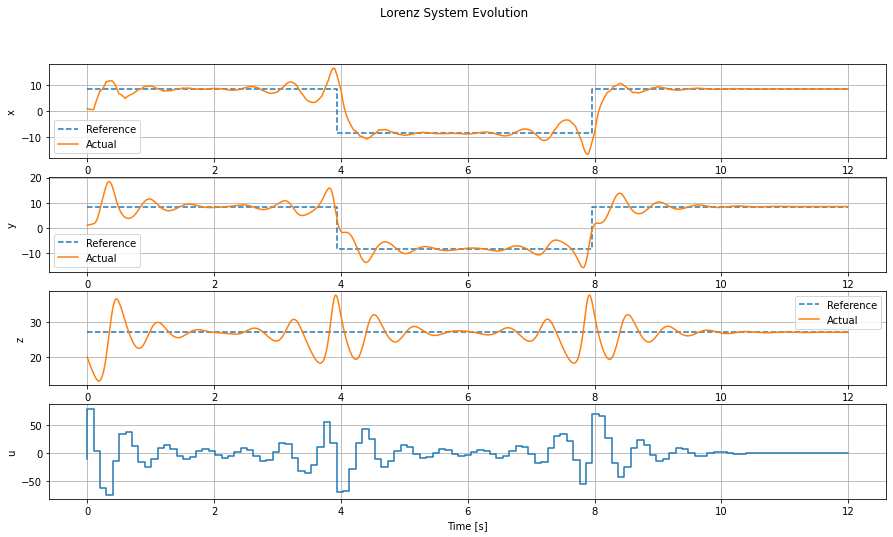

In [20]:
plt.figure(figsize=(15, 8))
plt.suptitle('Lorenz System Evolution')

for i in range(3):
    plt.subplot(411 + i)
    plt.grid()
    plt.step(np.linspace(0, TOTAL_TIME, TOTAL_STEP), x_ref[:TOTAL_STEP, i], '--', label='Reference')
    plt.plot(np.linspace(0, TOTAL_TIME, TOTAL_SAMPLE), x_actual[:, i], label='Actual')
    plt.ylabel(chr(ord('x') + i))
    plt.legend()
    
plt.subplot(414)
plt.grid()
plt.step(np.linspace(0, TOTAL_TIME, TOTAL_STEP), u_actual[:, 0])
plt.ylabel('u')

plt.xlabel('Time [s]')

plt.savefig('../report/images/mpc_lorenz', dpi=150, bbox_inches='tight')

# Animation

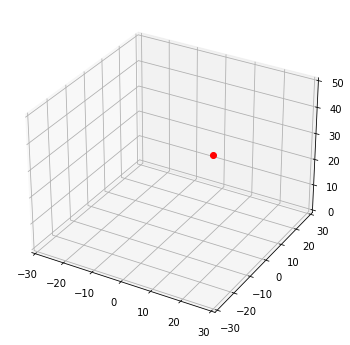

In [22]:
from physics.models import Lorenz
from matplotlib.animation import FuncAnimation

lorenz = Lorenz(0, 0, 0)
lorenz.init_draw()
ref_data, = lorenz.ax.plot([], [], [], 'ro')

INTERVAL = 5

def animate_func(i):
    i = i * INTERVAL
    lorenz.set_states(x=x_actual[i, 0], y=x_actual[i, 1], z=x_actual[i, 2])
    ref_data.set_data(np.array([x_ref[i//SCALE, 0]]), np.array([x_ref[i//SCALE, 1]]))
    ref_data.set_3d_properties(np.array([x_ref[i//SCALE, 2]]))
    line_data, = lorenz.draw()
    return line_data, ref_data

anim = FuncAnimation(lorenz.fig, func=animate_func, interval=INTERVAL*dt/SCALE*1e3, 
                     blit=True, frames=x_actual.shape[0] // INTERVAL)

In [23]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [407]:
anim.save('/home/alvin/Downloads/ECE 551 Final Project/lorenz.mp4', dpi=150)